# Step 1: Loading and Exploring the Dataset

Dataset shape: (1797, 64)


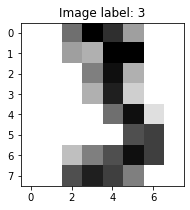

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Print the shape of the data
print("Dataset shape:", digits.data.shape)

# Display a sample image
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title(f"Image label: {digits.target[sample_index]}")
plt.show()

# Step 2: Preprocessing the Data

In [2]:
# Import preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Convert data to appropriate types
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37
)

# Normalize the data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1527, 64)
Test set shape: (270, 64)


# Step 3: Helper Functions

In [3]:
# One-hot encoding function
def one_hot(n_classes, y):
    y = np.array(y)  # Ensure NumPy array
    one_hot_encoded = np.zeros((y.size, n_classes))  # Zero matrix
    one_hot_encoded[np.arange(y.size), y] = 1  # Set 1 at correct indices
    return one_hot_encoded

# Test one-hot encoding
print("One-hot encoding for label 3:", one_hot(n_classes=10, y=3))
print("One-hot encoding for labels [0, 4, 9, 1]:\n", one_hot(n_classes=10, y=[0, 4, 9, 1]))

# Softmax function
def softmax(X):
    X = np.array(X)
    if X.ndim == 1:  # Single vector
        X = X - np.max(X)  # Stabilize
        exp_X = np.exp(X)
        return exp_X / np.sum(exp_X)
    elif X.ndim == 2:  # Matrix (batch)
        X = X - np.max(X, axis=1, keepdims=True)
        exp_X = np.exp(X)
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)

# Test softmax
print("\nSoftmax of [10, 2, -3]:", softmax([10, 2, -3]))
print("Sum of softmax:", np.sum(softmax([10, 2, -3])))  # Should be 1

# Negative log-likelihood (NLL) loss function
def nll(Y_true, Y_pred):
    Y_true = np.array(Y_true, dtype=np.float32)
    Y_pred = np.array(Y_pred, dtype=np.float32)
    epsilon = 1e-10  # Prevent log(0)
    Y_pred = np.clip(Y_pred, epsilon, 1.0)
    if Y_true.ndim == 1:  # Single example
        Y_true = Y_true.reshape(1, -1)
        Y_pred = Y_pred.reshape(1, -1)
    return -np.mean(np.sum(Y_true * np.log(Y_pred), axis=1))

# Test NLL
print("\nNLL of confident correct prediction:", nll([1, 0, 0], [.99, 0.01, 0]))  # Near 0
print("NLL of confident wrong prediction:", nll([1, 0, 0], [0.01, 0.01, .98]))  # Large

One-hot encoding for label 3: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
One-hot encoding for labels [0, 4, 9, 1]:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

Softmax of [10, 2, -3]: [9.99662391e-01 3.35349373e-04 2.25956630e-06]
Sum of softmax: 1.0

NLL of confident correct prediction: 0.010050327
NLL of confident wrong prediction: 4.6051702


# Step 4: Logistic Regression from Scratch

In [4]:
class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size), high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        self.output_size = output_size

    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        target = one_hot(self.output_size, y_true)
        if target.ndim > 1:
            target = target.squeeze()
        dnll_output = y_pred - target
        grad_W = x[:, np.newaxis] @ dnll_output[np.newaxis, :]
        grad_b = dnll_output
        return {"W": grad_W, "b": grad_b}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W -= learning_rate * grads["W"]
        self.b -= learning_rate * grads["b"]

    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        y_preds = self.forward(X)
        return np.mean(np.argmax(y_preds, axis=1) == y)

# Initialize the model
n_features = X_train.shape[1]
n_classes = 10
lr = LogisticRegression(n_features, n_classes)

# Evaluate untrained model
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)
print(f"Initial train loss: {train_loss:.4f}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}")

Initial train loss: 2.3487, train acc: 0.135, test acc: 0.122


# Step 5: Visualizing Predictions

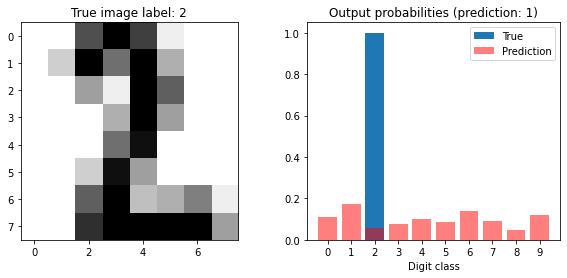

In [5]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # Display the image
    ax0.imshow(scaler.inverse_transform(X_test[sample_idx].reshape(1, -1)).reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title(f"True image label: {y_test[sample_idx]}")
    # Get probabilities and prediction
    probabilities = model.forward(X_test[sample_idx])
    predicted_label = model.predict(X_test[sample_idx])
    # Plot true vs predicted
    true_class = np.zeros(len(classes))
    true_class[y_test[sample_idx]] = 1
    ax1.bar(classes, true_class, label='True')
    ax1.bar(classes, probabilities, label='Prediction', color="red", alpha=0.5)
    ax1.set_xticks(classes)
    ax1.set_title(f'Output probabilities (prediction: {predicted_label})')
    ax1.set_xlabel('Digit class')
    ax1.legend()
    plt.show()

# Test with sample 0
plot_prediction(lr, sample_idx=0)

# Step 6: Training the Logistic Regression Model

Update #0, train loss: 2.3179, train acc: 0.157, test acc: 0.152
Update #100, train loss: 1.2927, train acc: 0.703, test acc: 0.744
Update #200, train loss: 0.8425, train acc: 0.867, test acc: 0.893
Update #300, train loss: 0.6269, train acc: 0.900, test acc: 0.911
Update #400, train loss: 0.5196, train acc: 0.910, test acc: 0.919
Update #500, train loss: 0.4507, train acc: 0.919, test acc: 0.937
Update #600, train loss: 0.3980, train acc: 0.924, test acc: 0.933
Update #700, train loss: 0.3620, train acc: 0.933, test acc: 0.959
Update #800, train loss: 0.3423, train acc: 0.936, test acc: 0.952
Update #900, train loss: 0.3167, train acc: 0.939, test acc: 0.944
Update #1000, train loss: 0.2949, train acc: 0.944, test acc: 0.948
Update #1100, train loss: 0.2772, train acc: 0.946, test acc: 0.952
Update #1200, train loss: 0.2662, train acc: 0.950, test acc: 0.959
Update #1300, train loss: 0.2568, train acc: 0.950, test acc: 0.948
Update #1400, train loss: 0.2412, train acc: 0.954, test acc

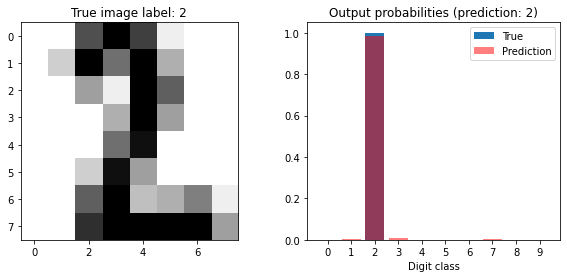

In [6]:
# Train for one epoch
learning_rate = 0.01
for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print(f"Update #{i}, train loss: {train_loss:.4f}, train acc: {train_acc:.3f}, test acc: {test_acc:.3f}")

# Visualize after training
plot_prediction(lr, sample_idx=0)

# Step 7: Neural Network from Scratch

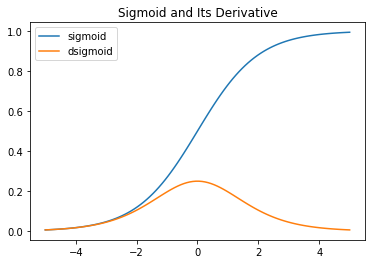

Initial loss: 2.3075292
Initial accuracy: 0.04387688277668631
Epoch 1, train loss: 0.30807, train acc: 0.938, test acc: 0.900
Epoch 2, train loss: 0.17507, train acc: 0.960, test acc: 0.926
Epoch 3, train loss: 0.11659, train acc: 0.977, test acc: 0.952
Epoch 4, train loss: 0.10316, train acc: 0.984, test acc: 0.956
Epoch 5, train loss: 0.07543, train acc: 0.987, test acc: 0.956
Epoch 6, train loss: 0.09254, train acc: 0.978, test acc: 0.933
Epoch 7, train loss: 0.04919, train acc: 0.992, test acc: 0.948
Epoch 8, train loss: 0.03995, train acc: 0.993, test acc: 0.948
Epoch 9, train loss: 0.03536, train acc: 0.994, test acc: 0.948
Epoch 10, train loss: 0.03093, train acc: 0.997, test acc: 0.948
Epoch 11, train loss: 0.02752, train acc: 0.997, test acc: 0.948
Epoch 12, train loss: 0.02479, train acc: 0.998, test acc: 0.952
Epoch 13, train loss: 0.02250, train acc: 0.998, test acc: 0.952
Epoch 14, train loss: 0.02065, train acc: 0.998, test acc: 0.952
Epoch 15, train loss: 0.01901, train 

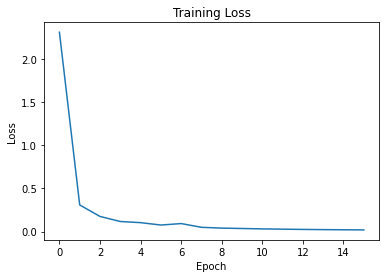

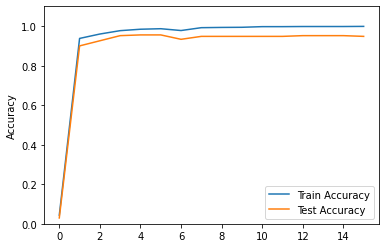

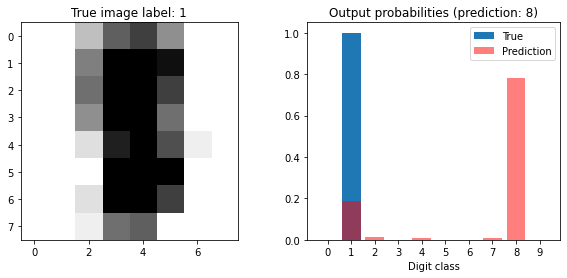

In [10]:
# Sigmoid activation and derivative
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    s = sigmoid(X)
    return s * (1 - s)

# Visualize sigmoid
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.title("Sigmoid and Its Derivative")
plt.legend()
plt.show()

class NeuralNet:
    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(low=-0.1, high=0.1, size=(input_size, hidden_size))
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(low=-0.1, high=0.1, size=(hidden_size, output_size))
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h

    def grad_loss(self, x, y_true):
        y, h, z_h = self.forward_keep_activations(x)
        target = one_hot(self.output_size, y_true)
        if target.ndim > 1:
            target = target.squeeze()
        grad_z_o = y - target
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, self.W_o.T)
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        if X.ndim == 1:
            X = X[np.newaxis, :]
        return np.mean(self.predict(X) == y)

# Initialize and test
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)
print("Initial loss:", model.loss(X_train, y_train))
print("Initial accuracy:", model.accuracy(X_train, y_train))

# Train for 15 epochs
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)
    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print(f"Epoch {epoch+1}, train loss: {losses[-1]:.5f}, train acc: {accuracies[-1]:.3f}, test acc: {accuracies_test[-1]:.3f}")

# Plot training progress
plt.figure()
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(accuracies, label='Train Accuracy')
plt.plot(accuracies_test, label='Test Accuracy')
plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Visualize prediction
plot_prediction(model, sample_idx=4)

# Step 8: Neural Network with TensorFlow

Epoch 0, Train acc: 0.121, Test acc: 0.078
Epoch 1, Train acc: 0.574, Test acc: 0.515
Epoch 2, Train acc: 0.759, Test acc: 0.737
Epoch 3, Train acc: 0.829, Test acc: 0.796
Epoch 4, Train acc: 0.872, Test acc: 0.848
Epoch 5, Train acc: 0.912, Test acc: 0.907
Epoch 6, Train acc: 0.940, Test acc: 0.933
Epoch 7, Train acc: 0.959, Test acc: 0.948
Epoch 8, Train acc: 0.969, Test acc: 0.956
Epoch 9, Train acc: 0.972, Test acc: 0.952


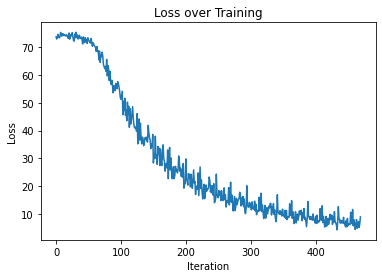

In [8]:
import tensorflow as tf

# Hyperparameters
batch_size = 32
hid_size = 15
learning_rate = 0.01
num_epochs = 10
input_size = X_train.shape[1]
output_size = 10

# Placeholders
X = tf.placeholder("float32", shape=[None, input_size])
y = tf.placeholder("int32", shape=[None])

# Weight initialization
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

# Model
W_h = init_weights([input_size, hid_size])
b_h = init_weights([hid_size])
h = tf.nn.sigmoid(tf.matmul(X, W_h) + b_h)
W_o = init_weights([hid_size, output_size])
b_o = init_weights([output_size])
out_act = tf.matmul(h, W_o) + b_o

# Loss and optimizer
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out_act, labels=y)
loss = tf.reduce_sum(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Prediction
predict = tf.nn.softmax(out_act)

# Training
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    losses = []
    for e in range(num_epochs):
        for i in range(X_train.shape[0] // batch_size):
            idx = i * batch_size
            idxn = min(X_train.shape[0], (i + 1) * batch_size)
            batch_xs, batch_ys = X_train[idx:idxn], y_train[idx:idxn]
            _, l = sess.run([train_op, loss], feed_dict={X: batch_xs, y: batch_ys})
            losses.append(l)
        # Accuracy
        predicts_train = sess.run(predict, feed_dict={X: X_train})
        predicts_test = sess.run(predict, feed_dict={X: X_test})
        train_acc = np.mean(np.argmax(predicts_train, axis=1) == y_train)
        test_acc = np.mean(np.argmax(predicts_test, axis=1) == y_test)
        print(f"Epoch {e}, Train acc: {train_acc:.3f}, Test acc: {test_acc:.3f}")
    
    # Plot loss
    plt.figure()
    plt.plot(losses)
    plt.title("Loss over Training")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()